# Optimizing the hyperparameter of which hyperparameter optimizer to use

In [1]:
__author__ = 'Ben Bernstein and Chris Potts'

__TL;DR__ We assess and compare two excellent open-source packages for hyperparameter optimization, Hyperopt and scikit-optimize. Our experiments use XGBoost classifiers on artificial datasets of various sizes, and the associated publicly available code permits a wide range of experiments with different classifiers and datasets. Overall, the experiments show that it is certainly worth using one of these packages (as opposed to exhaustive testing of the full space of parameters or random sampling from that space), but the experiments do not clearly differentiate Hyperopt and scikit-optimize &ndash; both are good choices.

0. [Introduction](#Introduction)
0. [Baseline methods](#Baseline-methods)
0. [Packages](#Packages)
0. [Data](#Data)
0. [Hyperparameter space](#Hyperparameter-space)
0. [Experimental set-up](#Experimental-set-up)
0. [Experiments](#Experiments)
0. [Use with scikit-learn models](#Use-with-scikit-learn-models)
0. [Conclusions](#Conclusions)

## Introduction

At Roam, we address a wide variety of problems that benefit from machine learning. There are many steps in this modeling process: translating one's intuitive hypothesis into a clear objective, gathering data, developing feature representations, preprocessing steps and checks, choosing assessment methods and metrics, model selection, and so on.

For this post, we'll assume you've already done all this hard work &ndash; the experimental set-up is established and the model is selected. The challenge of __hyperparameter optimization__ remains; whatever your model choice, it probably has between a few and a few dozen parameters that are outside of the optimization process. Common examples are the learning rate, the regularizers, the strength of those regularizers, the dimensionality of any hidden representations (for deep learning), the number of decision trees (for a random forest), and maybe even the optimization algorithm itself. 

Hyperparameter choices can have a significant impact on model performance. Setting them by hand and hoping for the best is extremely risky, and it won't do at all for model comparison, which calls for seeking to ensure that each model is given its best chance of winning or ending up in the final ensemble.

Luckily, there are a number of excellent open-source packages for hyperparameter optimization. With these tools, one need only set up a (potentially very large) space of hyperparameters to explore, and the tools will seek to find the best settings for the problem at hand. This greatly reduces the number of choices one has to make heuristically when doing machine learning.

In this post, we report on our internal assessment of two prominent open-source packages for hyperparameter optimization, Hyperopt and scikit-optimize. Not to get too meta, but you can think of this post as our own informal optimization of which hyperparameter optimization package to use. To score these packages, we balance accuracy and speed. All our code is available to enable testing with different datasets and models:

In [2]:
%matplotlib inline

In [ ]:
from hyperparameter_tuning_comparison_code import *

The requirements for this code are a bit finicky, so see the README.md for installation and usage notes.

## Baseline methods

We consider two common baseline approaches to finding the best hyperparameters:

* __Grid search__: an exhaustive search of every combination of every setting of the hyperparameters. This method is guaranteed to find the best settings in the (discrete version of the) search space, but it is simply not tractable for large parameter spaces.

* __Randomized search__: this method samples from the full grid. It doesn't offer the same guarantees as grid search, but it has been shown to be [extremely effective in practice](http://www.jmlr.org/papers/v13/bergstra12a.html).

## Packages

We assess two packages that support more sophisticated approaches. Both of them rely on [sequential model-based optimization](http://www.cs.ubc.ca/~hutter/papers/11-LION5-SMAC.pdf): at the start, they sample a small number of points from the full hyperparameter space and run evaluations using them. They then alternate between training regression models on the resulting `(setting, loss)` pairs and using those models to identify effective settings to add to the regression model data.

* [__Hyperopt__](http://hyperopt.github.io/hyperopt/): this package explores the hyperparameter space strategically using a [tree of Parzen estimators](http://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf), a Bayesian approach.

* [__Scikit-optimize__](https://github.com/scikit-optimize/scikit-optimize): this new package has three algorithms &ndash; `forest_minimize` (decision-tree regression search), `gbrt_minimize` (gradient-boosted-tree regression search), and `gp_minimize` (Gaussian process regression search).

There are two other prominent Python packages that we have not included in our evaluation: [Spearmint](https://github.com/HIPS/Spearmint) and [MOE](https://github.com/Yelp/MOE). The version of Spearmint under active development has a license that does not permit commercial work, and MOE has grown into the start-up [SigOpt](https://sigopt.com).

## Data

For this post, we rely on scikit-learn's (amazingly flexible) [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) method to create artificial datasets of various sizes. Our function `artificial_dataset` is a wrapper that permits fiddling with just a few of its many knobs. For instance, this creates a small dataset:

In [4]:
_ = artificial_dataset(
    n_samples=100, n_features=10, n_classes=3)

This is a tuple `(X, y)` where `X` is the matrix of feature representations and `y` is the target.

## Hyperparameter space

In this post, we use the XGBoost `XGBClassifier` as our base model. This a good choice for the post because it has a lot of hyperparameters to tune, but our main motivation is to keep the discussion manageable. As we noted above, the associated code supports experiments with many others, including all the scikit-learn models. (See below for [an example](#Use-with-sklearn-models).) 

For all the approaches we study, the basis for search is a dictionary mapping parameter names to values. However, the values need to be specified differently in each case. We've set them up so that they are as aligned as possible in terms of the space of values they define.

For the two baseline methods, grid search and randomized search, we specify the full list of values to be explored for each hyperparameter:

In [5]:
param_grid = {
    'max_depth' : [4, 8, 12],
    'learning_rate' : [0.01, 0.3, 0.5],
    'n_estimators' : [20, 50, 200],              
    'objective' : ['multi:softprob'],
    'gamma' : [0, 0.25, 0.5],
    'min_child_weight' : [1, 3, 5],
    'subsample' : [0.1, 0.5, 1],
    'colsample_bytree' : [0.1, 0.5, 1]}

For modeling, this will be expanded out into a very long list of `dict`s, each giving a different combination of the values for each list. This is the same as specifying the cross-product of all the parameter values, so it can result in very large spaces very quickly, which is why grid search is often not a tractable solution. The above creates 2,187 different settings.

For Hyperopt, the values are special `hyperopt` functions specifying distributions over parameter values:

In [6]:
hyperopt_grid = {
    'max_depth' : hp.choice('max_depth', range(4, 13, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'objective' : 'multi:softprob',
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 5, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

Search is then a process of sampling from these spaces.

Finally, scikit-optimize asks you to specify just the upper and lower bounds of the space to be searched:

In [7]:
skopt_grid = {
    'max_depth': (4, 12),
    'learning_rate': (0.01, 0.5), 
    'n_estimators': (20, 200), 
    'objective' : Categorical(('multi:softprob',)),
    'gamma': (0, 0.5), 
    'min_child_weight': (1, 5),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1)}

Actually, `skopt` wants to operate on lists of lists of values, rather than this `dict`. That makes it hard to keep track of which parameters are being specified, so our code handles the internal conversions from `dict` to `list` and back to `dict`.

## Experimental set-up

Our experimental set-up seeks to make maximal use of the available data. The procedure:

0. __Outer five-fold cross-validation__: the full dataset is divided into five sections (folds). This creates five experimental settings, in which we train on four of the folds (merged together) and test on the fifth.

0. __Inner five-fold cross-validation__: For each experimental setting, the training set is used to find the optimal hyperparameters &ndash; for each setting of the hyperparameters, a full round of five-fold cross-validation is performed using only the training data. 

0. The hyperparameter setting that does best at step 2 is the basis for the model that is used for testing in the outer cross-validation.

Here's a more schematic way of thinking about it:

> For each (`train_folds`, `test_fold`) in the outer cross-validation:<br />
>> For each setting `S` of the hyperparameters:<br />
>>> Cross-validate `S` on `train_folds`.<br />

>> Let `S*` be the setting that did best in the inner loop.<br />
>> Use `S*` to assess on `test_fold`.

To keep the comparisons simple, we're assuming no parallelization. In a way, we're implicitly assuming that all these packages are equally efficient when run in parallel. This is almost certainly not correct, so it would be worthwhile to do a separate assessment of how these packages take advantage of parallelization.

The hyperparameter optimization methods have their own hyperparameters. To avoid one more step in a potentially infinite regress of optimization problems, we have simply fixed these as follows:

* Random search: the number of settings sampled is half the number of total samples for small experiments and 100 for large ones.
* Hyperopt search: the `max_evals` flag is set to 100.
* Scikit-optimize search methods: `n_calls` is set to 100 (the default) and all the other parameters are set to their defaults as well.

The function `run_experiments` in the codebase is a flexible interface for running experiments. The next section illustrates its usage and reports on some of our assessments of these packages and approaches.

## Experiments

There are numerous paths we could take for evaluation. Because we're using `make_classification` to create datasets, we're not at the mercy of available labeled corpora, so many of these paths are open to us. We'll report on just a few.

### A small dataset

To start, let's create a dataset with just 1000 examples and 100 features. At this scale, we can afford to do our full experimental run: full grid-search, half of the grid sampled during random search, and 100 model evaluations for the Hyperopt and scikit-optimize algorithms:

In [8]:
full_experimental_run = [
    (grid_search, param_grid, {}),
    (random_search, param_grid, {'sampsize': None}),
    (hyperopt_search, hyperopt_grid, {'max_evals': 100}),
    (skopt_gp_search, skopt_grid,  {'n_calls': 100}),
    (skopt_forest_search, skopt_grid, {'n_calls': 100}),
    (skopt_gbrt_search, skopt_grid, {'n_calls': 100})]

The following creates this dataset and runs all our evaluations on it:

In [9]:
small_dataset = artificial_dataset(
    n_samples=1000, n_features=100, n_classes=3)

In [10]:
full_experimental_run = [
    (skopt_gp_search, skopt_grid,  {'n_calls': 100}),
    (skopt_forest_search, skopt_grid, {'n_calls': 100}),
    (skopt_gbrt_search, skopt_grid, {'n_calls': 100})]

In [11]:
small_results = run_experiments(
    full_experimental_run, small_dataset)

In [12]:
prepare_summaries(small_results).round(3)

,Method,Mean parameters sampled,Mean test accuracy,Mean cross-validation time (in secs.)
1,grid_search,2187.0,0.723,4204.464
2,random_search,1093.0,0.669,2102.511
3,hyperopt_search,100.0,0.700,376.431
4,skopt_gp_minimize,100.0,0.696,381.572
5,skopt_forest_minimize,100.0,0.705,414.820
6,skopt_forest_gbrt,100.0,0.716,399.474


Here, all the models perform about the same, but Hyperopt and scikit-optimize show their value in the time it takes to achieve these results: they are about five times faster than `random_search` and ten times faster than `grid_search`.

### Random search with fewer samples

The above results are unrealistic in the sense that they assume we have sufficient resources and time to do full grid search and take very large samples from the grid for random search. In practice (as we move to having tens or hundreds of thousands of examples), we're unlikely to have these luxuries. It's thus worth seeing what happens if we place random search more on a par with the other methods by taking just 100 samples from the grid, using the same dataset of 1000 examples and 100 features. Here's what we find:

In [13]:
limited_random_search_run = [
    (random_search, param_grid, {'sampsize': 100})]

In [14]:
limited_random_search_results = run_experiments(
    limited_random_search_run, small_dataset)

In [15]:
prepare_summaries(limited_random_search_results).round(3)

,Method,Mean parameters sampled,Mean test accuracy,Mean cross-validation time (in secs.)
1,random_search,100.0,0.672,180.609


This one-line table can be thought of as an extension of the above. Here, we see clearly that the strong showing of random search (and grid search) was due to their brute-force approach. Sampling 1,093 settings is much different from sampling just a 100 when it comes to happening by chance upon a good model! In sum, Hyperopt and Scikit-optimize earn their keep not only in terms of speed but also in terms of expected performance.

### A larger dataset

The following defines a dataset with 10K examples and just 20 features, which might correspond to a situation in which one has a small number of highly informative predictors derived from structured information:

In [16]:
large_dataset = artificial_dataset(
    n_samples=10000, n_features=20, n_classes=3)

For experiments of this size, grid search is basically infeasible given our rigorous evaluation set-up, so we don't do it. Furthermore, sampling half of the settings from that grid is likely to be too costly. Thus, we again specify that just 100 settings will be sampled, for a run that is more comparable to what we're allowing Hyperopt and scikit-optimize:

In [17]:
partial_experimental_run = [
    (random_search, param_grid, {'sampsize': 100}),
    (hyperopt_search, hyperopt_grid, {'max_evals': 100}),
    (skopt_gp_search, skopt_grid,  {'n_calls': 100}),
    (skopt_forest_search, skopt_grid, {'n_calls': 100}),
    (skopt_gbrt_search, skopt_grid, {'n_calls': 100})]

In [18]:
large_results = run_experiments(
    partial_experimental_run, large_dataset)

In [19]:
prepare_summaries(large_results).round(3)

,Method,Mean parameters sampled,Mean test accuracy,Mean cross-validation time (in secs.)
1,random_search,100.0,0.944,755.641
2,hyperopt_search,100.0,0.946,1402.625
3,skopt_gp_minimize,100.0,0.946,1398.443
4,skopt_forest_minimize,100.0,0.945,1328.926
5,skopt_forest_gbrt,100.0,0.945,1442.400


These results suggest that one's choice of hyperparameter optimization routine is less crucial for large datasets with dense, short feature representations. Here, `random_search` is actually the fastest choice, because sampling and evaluating a mere 100 random settings is much easier than the iterative model-fitting and exploration performed by the other methods, and the precise setting of those parameters just doesn't matter all that much for this dataset.

### Experiments with increasingly large feature sets

To finish our experimental evaluation, let's focus on a specific question: __what happens as the number of features grows larger (perhaps much larger) than the number of examples?__ Such situations place special pressure on various classifier hyperparameters, especially those related to regularization. 

To do this, we create datasets with 100 examples and feature sets in sizes from 50 to 500 in increments of 50. This is a simple loop over `run_experiment`; in the codebase, the function is `representation_size_experiments`.

For these small datasets, we can afford to do a full grid search and sample half of the settings in random search, so `full_experimental_run` is again the basis for the evaluation:

In [20]:
representation_size_results = representation_size_experiments(
    full_experimental_run,
    n_samples=100,
    min_features=50,
    max_features=100,
    increment=50)

The results for accuracy are kind of a wash, as the following plot shows; the confidence interval bars overlap a lot, creating a messy display, but that actually helps to convey that the numerical differences are not especially reliable.

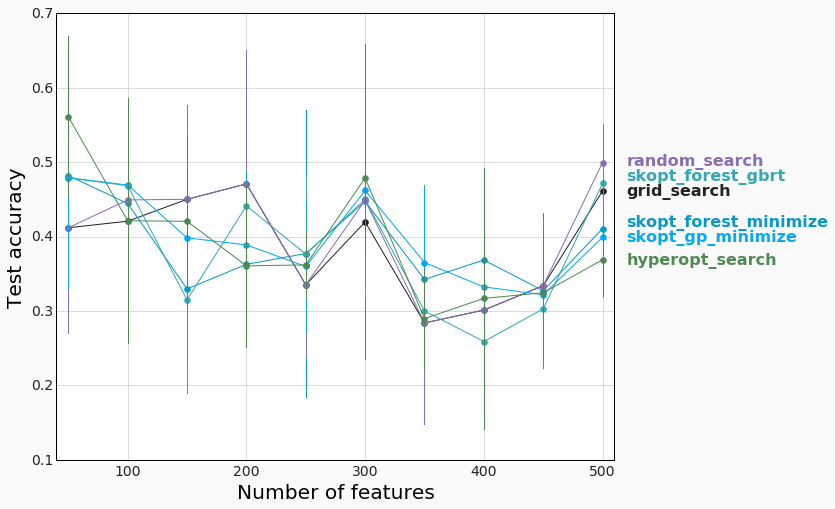

In [21]:
plot_representation_size_accuracy(
    representation_size_results, include_cis=True)

However, when we look at the __time__ it took to create these basically indistinguishable results, they strongly favor the hyperparameter optimization packages over the two baselines. In fact, the differences are so large that we have had to use a log-scale y-axis:

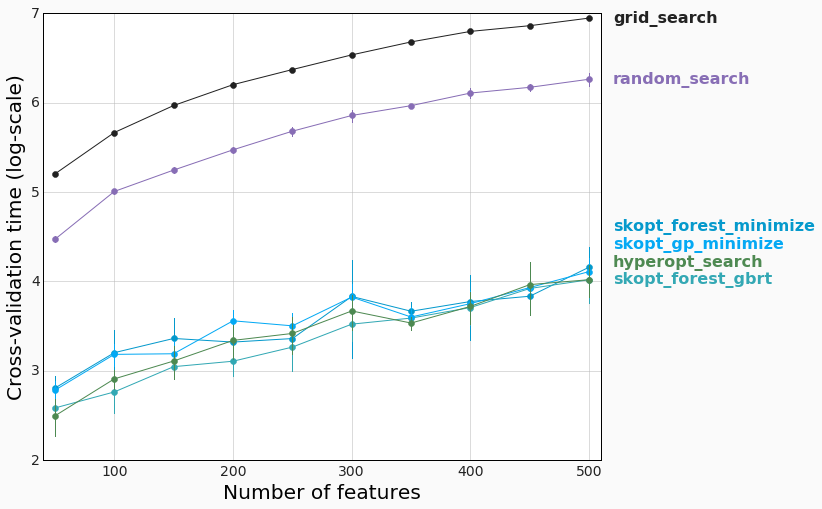

In [22]:
plot_representation_size_time(
    representation_size_results, include_cis=True)

To take one example, where there were 500 features, `random_search` took an average of 17 minutes, whereas `hyperopt_search` averaged less than 1 minute.

In summary, for these experiments, we don't see a big difference between Hyperopt and scikit-optimize, but both are clearly better than the baselines because of their speed.

## Use with scikit-learn models

The framework above can easily accommodate scikit-learn models. To illustrate, here are parameter grids for assessing all of the approaches with a `LogisticRegression` (maximum entropy, softmax) classifier:

In [23]:
from skopt.space import Categorical

maxent_param_grid = {
    'C': np.logspace(-2.0, 10.0, 10), 
    'penalty': ['l1', 'l2'], 
    'fit_intercept': [True, False]}

maxent_hyperopt_grid = {
    'C': hp.quniform('C', 0.01, 1.0, 0.01),
    'penalty': hp.choice('penalty', ['l2', 'l1']),
    'fit_intercept': hp.choice('fit_intercept', [True, False])}

maxent_skopt_grid = {
    'C': (0.001, 100.0), 
    'penalty': Categorical(('l1', 'l2')),
    'fit_intercept': Categorical((True, False))}

And here's an example assessment:

In [24]:
X_small, y_small = small_dataset

sklearn_results = assess(
    X_small,
    y_small, 
    skopt_gp_search,
    LogisticRegression, 
    param_grid=maxent_skopt_grid,
    xval_indices=get_cross_validation_indices(X_small, y_small),
    dataset_name='small')

In [25]:
prepare_summary(sklearn_results)

,Method,Mean parameters sampled,Mean test accuracy,Mean cross-validation time (in secs.)
0,skopt_gp_minimize,100.0,0.719134,109.511254


## Conclusions

The above experiments show that grid search and randomized search are needlessly expensive to run. Hyperopt and scikit-optimize consistently perform better, in that they deliver more effective models faster. Since they are easy to use, they are clear winners. Our current results do not  favor one package over the other, but this could change as the packages evolve.